In [27]:
from tensorflow.keras.datasets import mnist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
class  ANN_perceptron:
    def __init__(self):
        pass
    
    def sigmoid(self, Z):      
        A = 1/(1+np.exp(-Z))       
        return A
    
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
    
    def relu(self, Z):
        A = np.maximum(0,Z)
        cache = Z 
        return A

    def deep_initialize_parameters(self, layer_dims):
        np.random.seed(1)
        parameters = {}
        L = len(layer_dims)            # number of layers in the network

        for l in range(1, L):
            parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])/np.sqrt(layer_dims[l-1])# *0.01
            parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        return parameters

    def linear_activation_forward(self,A_prev, W, b, activation):
        Z = np.dot(W,A_prev) + b
        linear_cache = (A_prev, W, b)

        if activation == "softmax":    
            A = self.softmax(Z)
        elif activation == "relu":
            A = self.relu(Z)

        cache = (linear_cache, Z)
        return A, cache

    
    def deep_model_forward(self,X, parameters):
        caches = []
        A = X
        L = len(parameters) // 2  
        for l in range(1, L):
            A_prev = A 
            A, cache = self.linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
            caches.append(cache)

        AL, cache = self.linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "softmax")
        caches.append(cache)
        return AL, caches

    def compute_cost(self,AL, Y):
        m = Y.shape[1]
        cost = (-1/m)*np.sum(Y * np.log(AL))
        cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
        assert(cost.shape == ())
        return cost

    def linear_backward(self,dZ, cache):
        A_prev, W, b = cache
        m = A_prev.shape[1]

        dW = 1./m * np.dot(dZ,A_prev.T)
        db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
        dA_prev = np.dot(W.T,dZ)
        return dA_prev, dW, db    

    def relu_backward(self,dA, cache):
        Z = cache
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        assert (dZ.shape == Z.shape)
        return dZ
    
    def sigmoid_backward(self, dA, cache):
        Z = cache    
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
        assert (dZ.shape == Z.shape)    
        return dZ

    def softmax_backward(self,AL,Y,cache):
        Z = cache
        dZ = AL - Y
        assert (dZ.shape == Z.shape)
        return dZ 
    
    def linear_activation_backward(self,Y,AL,dA, cache, activation):
        linear_cache, activation_cache = cache
        if activation == "softmax":
            dZ = self.softmax_backward(AL,Y,activation_cache)
            dA_prev, dW, db = self.linear_backward(dZ, linear_cache)

        elif activation == "relu":
            dZ = self.relu_backward(dA, activation_cache)
            dA_prev, dW, db = self.linear_backward(dZ, linear_cache)

        return dA_prev, dW, db


    def deep_model_backward(self,AL, Y, caches):
        grads = {}
        L = len(caches) # the number of layers
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)

        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

        current_cache = caches[L-1]
        grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = self.linear_activation_backward(Y,AL,dAL, current_cache, activation = "softmax")
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.linear_activation_backward(Y,AL,grads["dA" + str(l + 2)], current_cache, activation = "relu")
            grads["dA" + str(l + 1)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp

        return grads
 

    def update_parameters(self,parameters, grads, learning_rate):
        L = len(parameters) // 2
        for l in range(L):
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

        return parameters

    def deep_layer_model(self,X, Y, layers_dims, learning_rate, num_iterations): #lr was 0.009
        costs = []
        parameters = self.deep_initialize_parameters(layers_dims)
        for i in range(0, num_iterations):
            AL, caches = self.deep_model_forward(X, parameters)
            cost = self.compute_cost(AL, Y)
            grads = self.deep_model_backward(AL, Y, caches)
            parameters = self.update_parameters(parameters, grads, learning_rate)
            costs.append(cost)
            if i % 100 == 0:
                print ("Cost after iteration %i: %f" % (i, cost))
        return parameters, costs
    
    def predict(self,params, X, Y):
        probs, caches = self.deep_model_forward(X, params) 
        y_hat = np.argmax(probs, axis=0)
        Y = np.argmax(Y, axis=0)
        conf_matrix=self.compute_confusion_matrix(Y, y_hat)
        print("label precision recall")
        for label in range(5):
            print(f"{label:5d} {self.precision(label, conf_matrix):9.3f} {self.recall(label, conf_matrix):6.3f}")

        accuracy = self.accuracy(conf_matrix)
        print("Test Accuracy: ",accuracy)        
        return conf_matrix
    
    def compute_confusion_matrix(self,true, pred):
        K = len(np.unique(true)) # Number of classes 
        result = np.zeros((K, K))
        for i in range(len(true)):
            result[true[i]][pred[i]] += 1
        return result

    def precision(self,label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()

    def recall(self,label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()
    
    def accuracy(self,confusion_matrix):
        diagonal_sum = confusion_matrix.trace()
        sum_of_all_elements = confusion_matrix.sum()
        return diagonal_sum / sum_of_all_elements

In [29]:
def main():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

    X_TRAIN=[]
    Y_TRAIN=[]
    for i in range(len(y_train)):
        if y_train[i]<5:
            X_TRAIN.append(x_train[i])
            Y_TRAIN.append(y_train[i])

    X_TEST=[]
    Y_TEST=[]
    for i in range(len(y_test)):
        if y_test[i]<5:
            X_TEST.append(x_test[i])
            Y_TEST.append(y_test[i])

    X_TRAIN=np.array(X_TRAIN)
    Y_TRAIN=np.array(Y_TRAIN)

    X_TEST=np.array(X_TEST)
    Y_TEST=np.array(Y_TEST)
    Y_Train = np.zeros((len(Y_TRAIN),5))
    for i in range(len(Y_TRAIN)):
        Y_Train[i,Y_TRAIN[i]] = 1

    Y_Test = np.zeros((len(Y_TEST),5))
    for j in range(len(Y_TEST)):
        Y_Test[j,Y_TEST[j]] = 1
    XX_train = X_TRAIN.astype('float32') / 255.
    XX_test = X_TEST.astype('float32') / 255.
    XX_train = XX_train.T
    XX_test =XX_test.T
    Y_train = Y_Train.T
    Y_test = Y_Test.T
    regressor =  ANN_perceptron()
    layers_dims = [XX_train.shape[0], 256, 64,32,5]
    print(len(layers_dims))
    par, costs = regressor.deep_layer_model(XX_train, Y_train, layers_dims, learning_rate=0.1, num_iterations=1000)
    plt.plot(range(len(costs)),costs)
    plt.xlabel("Iterations")
    plt.ylabel("Cost")
    plt.title("Costs vs iterations")
    print("Confusion Matrix: ",regressor.predict(par, XX_test, Y_test))

5
Cost after iteration 0: 1.620998
Cost after iteration 100: 0.135890
Cost after iteration 200: 0.103918
Cost after iteration 300: 0.088841
Cost after iteration 400: 0.078111
Cost after iteration 500: 0.069255
Cost after iteration 600: 0.061610
Cost after iteration 700: 0.054896
Cost after iteration 800: 0.048953
Cost after iteration 900: 0.043698
label precision recall
    0     0.992  0.996
    1     0.996  0.994
    2     0.979  0.972
    3     0.988  0.989
    4     0.987  0.991
Test Accuracy:  0.9883245767659078
Confusion Matrix:  [[9.760e+02 0.000e+00 2.000e+00 1.000e+00 1.000e+00]
 [1.000e+00 1.128e+03 6.000e+00 0.000e+00 0.000e+00]
 [6.000e+00 5.000e+00 1.003e+03 1.000e+01 8.000e+00]
 [0.000e+00 0.000e+00 7.000e+00 9.990e+02 4.000e+00]
 [1.000e+00 0.000e+00 7.000e+00 1.000e+00 9.730e+02]]


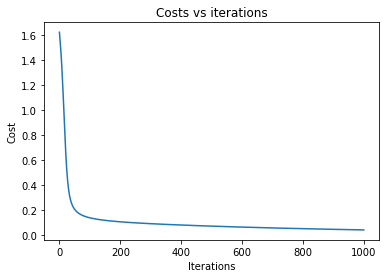

In [30]:
if __name__ == '__main__':

    main()